# Sea ice and ocean data access and analysis 

Accessing coincident sea ice and ocean data to study melt pond characteristics.

Intro to use case, motivation, connections to cloud migration, learning objectives...

## Explore NASA Earthdata sea ice and ocean products...

... highlight key search terms and data availability across NASA DAACs...

## Import packages

In [3]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from pprint import pprint
import getpass
import requests
import json
import random
from statistics import mean
import pandas as pd
import geopandas
import os
from xml.etree import ElementTree as ET
import shutil
import time
import zipfile
import io
import xarray as xr
import h5py
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'gql'

## Data Discovery

Start by identifying your study area and exploring coincident data over the same time and area.

NASA Earthdata Search can be used to visualize file coverage over mulitple data sets and to access the same data you will be working with below: [insert URL with same search here]


### Identify time and area of interest


Study area: Using OA melt pond annotation as an example: https://openaltimetry.org/data/icesat2/?start_date=2019-06-22&annoId=180

- Temporal coverage: 22 June 2019
- Bounding area: -62.8,81.7,-56.4,83



<img align="left"
     src="OpenAltimetry-study-area.png">

In [ ]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-62.8,81.7,-56.4,83'
# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-22T23:59:59Z'

### Explore data availability using the Common Metadata Repository
The Common Metadata Repository (CMR) is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. These metadata records are registered, modified, discovered, and accessed through programmatic interfaces leveraging standard protocols and APIs.

General CMR API documentation: https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html

***[below is background for development - will not include in final notebook]***

#### Configure a CMR GraphQL client
Using qgl we can communicate with the CMR GraphQL endpoint in a standards-based way, allowing for schema introspection. gql isn't the only python GraphQL client library out there. Other libraries might provide features you value, like gql-next's static type generation functionality.

GraphQL endpoint documentation and interactive playground: https://graphql.earthdata.nasa.gov/api

In [2]:
CMR_GRAPHQL_URL = 'https://graphql.earthdata.nasa.gov/api'
sample_transport=RequestsHTTPTransport(
    url=CMR_GRAPHQL_URL,
    retries=3,            # Automatically retry, don't put it on the user!
)

client = Client(
    transport=sample_transport,
    fetch_schema_from_transport=True,  # Get the schema as part of the client object
)

collection_schema = client.schema.get_type('Collection')

# Show info about 5 random fields
sample_fields = random.sample(list(collection_schema.fields.items()), 5)
for fieldname, field in sample_fields:
    print(f'* {fieldname}: {field.description}')

NameError: name 'RequestsHTTPTransport' is not defined

### Select data sets and determine version numbers

Data products:
- Sea Surface Temperature: 
    * MODIS (Terra) SST: MODIS_T-JPL-L2P-v2014.0
    * _SMAP SSS L3 expected in cloud Ops starting with 20.4.2._
    * _GRACE-FO in cloud Ops now._
    * Hooked up to L2SS now:
        * C1940473819-POCLOUD (MODIS_A-JPL-L2P-v2019.0)
        * C1940475563-POCLOUD (MODIS_T-JPL-L2P-v2019.0)
        * C1940466008-POCLOUD (MERGED_TP_J1_OSTM_OST_CYCLES_V42)
- Sea Ice Height
    * ATL07

Data sets are selected by data set IDs (e.g. ATL07). In the CMR API documentation, a data set ids is referred to as a "short name". These short names are located at the top of each NSIDC data set landing page in gray above the full title. We are using the Python Requests package to access the CMR. Data are then converted to JSON format; a language independant human-readable open-standard file format. More than one version can exist for a given data set:

In [4]:
sst_query = gql('''
query { 
  collections(shortName: "MODIS_T-JPL-L2P-v2014.0") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
    }
  }
}
''')

sst_response = client.execute(sst_query)
pprint(sst_response)

height_query = gql('''
query { 
  collections(shortName: "ATL07") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
    }
  }
}
''')

height_response = client.execute(height_query)
pprint(height_response)


{'collections': {'items': [{'conceptId': 'C1648596996-PODAAC',
                            'datasetId': 'GHRSST Level 2P Global Skin Sea '
                                         'Surface Temperature from the '
                                         'Moderate Resolution Imaging '
                                         'Spectroradiometer (MODIS) on the '
                                         'NASA Terra satellite',
                            'shortName': 'MODIS_T-JPL-L2P-v2014.0',
                            'versionId': '2014.0'}]}}
{'collections': {'items': [{'conceptId': 'C1631076780-NSIDC_ECS',
                            'datasetId': 'ATLAS/ICESat-2 L3A Sea Ice Height '
                                         'V002',
                            'shortName': 'ATL07',
                            'versionId': '002'},
                           {'conceptId': 'C1706334166-NSIDC_ECS',
                            'datasetId': 'ATLAS/ICESat-2 L3A Sea Ice Height '
                

We will specify the most recent version for our remaining data set queries.

### Determine how many files exist over this time and area of interest, as well as the average size and total volume of those files


In [5]:
# NOTE: GraphQL endpoint currently supports selecting granules by conceptId, not short_name, versionId.
query = gql('''
query {
  granules(conceptId: "C1706334166-NSIDC_ECS"
           boundingBox: "-62.8,81.7,-56.4,83"
           temporal: "2019-06-22T00:00:00Z,2019-06-22T23:59:59Z"
           limit: 100) {
    count
    items { granuleSize }
           
  }
}
''')
response = client.execute(query)

granule_sizes = [float(i['granuleSize']) for i in response['granules']['items']][:]

print(f"Found {response['granules']['count']} files")
print(f"Average size: {mean(granule_sizes):.2f}")
print(f"Total size: {sum(granule_sizes):.2f}")

Found 2 files
Average size: 230.85
Total size: 461.70


### ***On your own: Discover data availability for MODIS Skin Sea Surface Temperature: NOTE THAT WE NEED TO INCLUDE CMR TOKEN IN POCLOUD SEARCH SINCE THESE ARE RESTRICTED***
Replace the ATL07 `conceptID` value with the MODIS Skin Sea Surface Temperature `conceptID` value returned above. How do the number of files and the data volume compare to ATL07?

Note that subsetting, reformatting, or reprojecting can alter the size of the granules if those services are applied to your request.



## Data Access and Subsetting

Depending on the NSIDC data set, we could utilize CMR UMM-S associations to demonstrate ESI subsetting service availability. Or for "native" data access, we could also access using Harmony (all CMR data can be accessed using Harmony no-proc service), or just through CMR data access URLs. 

The PO DAAC data can be subsetted via Harmony subsetting service. (Insert Harmony landing page when available!!)

### Determine subsetting capabilties...


Using UMM-S association for ATL07 to determine service availability:

In [7]:
height_query = gql('''
query { 
  collections(conceptId: "C1706334166-NSIDC_ECS") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
      services {
          items {
          serviceOptions
          }
      }
    }
  }
}
''')

height_response = client.execute(height_query)
pprint(height_response['collections'])

{'items': [{'conceptId': 'C1706334166-NSIDC_ECS',
            'datasetId': 'ATLAS/ICESat-2 L3A Sea Ice Height V003',
            'services': {'items': [{'serviceOptions': {'subset': {}}},
                                   {'serviceOptions': {'subset': {'spatialSubset': {'boundingBox': {'allowMultipleValues': False},
                                                                                    'shapefile': [{'format': 'ESRI'},
                                                                                                  {'format': 'KML'},
                                                                                                  {'format': 'GeoJSON'}]},
                                                                  'temporalSubset': {'allowMultipleValues': False},
                                                                  'variableSubset': {'allowMultipleValues': True}},
                                                       'supportedReformattings': [{'support

We can also do this for the MODIS SST data set (pending UMM-S and L2SS connection?)

In [8]:
sst_query = gql('''
query { 
  collections(conceptId: "C1648596996-PODAAC") {
    items { 
      shortName
      datasetId
      conceptId
      versionId
      services {
          items {
          serviceOptions
          }
      }
    }
  }
}
''')

sst_response = client.execute(sst_query)
pprint(sst_response['collections'])

{'items': [{'conceptId': 'C1648596996-PODAAC',
            'datasetId': 'GHRSST Level 2P Global Skin Sea Surface Temperature '
                         'from the Moderate Resolution Imaging '
                         'Spectroradiometer (MODIS) on the NASA Terra '
                         'satellite',
            'services': {'items': None},
            'shortName': 'MODIS_T-JPL-L2P-v2014.0',
            'versionId': '2014.0'}]}


For our purposes, even though there are several other options for spatial area input like shapefile (see other tutorial for this!), we'll use a simple bounding box to crop our data to that area. 

### Data Access

Prior to migrating to AWS, ATL07 is accessed using an NSIDC-specific API:

In [9]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# bounding box search and subset:
param_dict = {'short_name': 'ATL07', 
              'version': '003', 
              'temporal': temporal, 
              'bounding_box': bounding_box, 
              'bbox': bounding_box, 
              'page_size': '10', 
              'request_mode': 'async',
              'email': 'amy.steiker@nsidc.org', }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

API_request = api_request = f'{base_url}?{param_string}'
print(API_request)

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL07&version=003&temporal=2019-06-22T00:00:00Z,2019-06-22T23:59:59Z&bounding_box=-62.8,81.7,-56.4,83&bbox=-62.8,81.7,-56.4,83&page_size=10&request_mode=async&email=amy.steiker@nsidc.org


Earthdata Search session (from https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+Python):

In [10]:
username = 'amy.steiker' # Enter Earthdata Login user name'
password = getpass.getpass('Earthdata Login password: ') # Enter Earthdata Login password

Earthdata Login password:  ·········


In [12]:
path = str(os.getcwd() + '/Outputs') # Create an output folder if the folder does not already exist.
if not os.path.exists(path):
    os.mkdir(path)
        
with requests.Session() as session:
    session.auth = (username, password)
    r = session.get(API_request)
    if r.ok:
        print('Order request URL: ', r.url)
        esir_root = ET.fromstring(r.content)
        orderlist = []   # Look up order ID
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)
        statusURL = base_url + '/' + orderID # Create status URL
        print('status URL: ', statusURL)
        request_response = session.get(statusURL) # Find order status  
        if request_response.ok:        
            request_root = ET.fromstring(request_response.content)
            statuslist = []
            for status in request_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Initial request status is ', status)
        while status == 'pending' or status == 'processing': #Continue loop while request is still processing
            print('Status is not complete. Trying again.')
            time.sleep(15)
            loop_response = session.get(statusURL)
            loop_response.raise_for_status() # Raise bad request: Loop will stop for bad response code.
            loop_root = ET.fromstring(loop_response.content)
            statuslist = [] #find status
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue
        if status == 'complete_with_errors' or status == 'failed': # Provide complete_with_errors error message:
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint(messagelist)
        if status == 'complete' or status == 'complete_with_errors':# Download zipped order if status is complete or complete_with_errors
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            zip_response.raise_for_status() # Raise bad request: Loop will stop for bad response code.
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request is complete.')
        else: print('Request failed.')

Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL07&version=003&temporal=2019-06-22T00:00:00Z,2019-06-22T23:59:59Z&bounding_box=-62.8,81.7,-56.4,83&bbox=-62.8,81.7,-56.4,83&page_size=10&request_mode=async&email=amy.steiker@nsidc.org
order ID:  5000000920813
status URL:  https://n5eil02u.ecs.nsidc.org/egi/request/5000000920813
Initial request status is  complete
Zip download URL:  https://n5eil02u.ecs.nsidc.org/esir/5000000920813.zip
Beginning download of zipped output...
Data request is complete.


In [45]:
# Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))

MODIS SST Data Access through Harmony:

In [14]:
harmony_root = 'https://harmony.earthdata.nasa.gov'

bboxSubsetConfig = {
    'collection_id': 'C1940475563-POCLOUD',
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat': '(81.7:83)',
    'lon': '(-62.8:-56.4)',
    'time': '("2019-06-22T00:00:00Z":"2019-06-22T23:59:59Z")'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&subset=lat{lat}&subset=lon{lon}&subset=time{time}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)
r = session.get(bbox_url)
bbox_response = r.content
async_json = json.loads(bbox_response)
pprint(async_json)


jobConfig = {
    'jobID': async_json['jobID']
}

job_url = harmony_root+'/jobs/{jobID}'.format(**jobConfig)
print('Job URL', job_url)

job_response = session.get(job_url)
job_results = job_response.content
job_json = json.loads(job_results)

print('Job response:')
print()
pprint(job_json)


#Continue loop while request is still processing
while job_json['status'] == 'running' and job_json['progress'] < 100: 
    print('Job status is running. Progress is ', job_json['progress'], '%. Trying again.')
    time.sleep(10)
    loop_response = session.get(job_url)
    loop_results = loop_response.content
    job_json = json.loads(loop_results)
    if job_json['status'] == 'running':
        continue

if job_json['progress'] == 100:
    print('Job progress is 100%. Output links printed below:')
    links = [link for link in job_json['links'] if link.get('rel', 'data') == 'data'] #list of data links from response
    for i in range(len(links)):
        link_dict = links[i] 
        print(link_dict['href'])
        filepath = link_dict['href'].split('/')[-1]
        file_ = open(filepath, 'wb')
        response = session.get(link_dict['href'])
        file_.write(response.content)
        file_.close()

Request URL https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&subset=lat(81.7:83)&subset=lon(-62.8:-56.4)&subset=time("2019-06-22T00:00:00Z":"2019-06-22T23:59:59Z")
{'createdAt': '2020-11-10T18:50:16.017Z',
 'jobID': '2a57ba06-7593-46cb-86aa-5df57dd77d3b',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/2a57ba06-7593-46cb-86aa-5df57dd77d3b',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'}],
 'message': 'The job is being processed',
 'progress': 0,
 'request': 'https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lat(81.7%3A83)&subset=lon(-62.8%3A-56.4)&subset=time(%222019-06-22T00%3A00%3A00Z%22%3A%222019-06-22T23%3A59%3A59Z%22)',
 'status': 'running',
 'updatedAt': '2020-11-10T18:50:16.017Z',
 'username': 'amy.steiker'}
Job URL https://harmony.earthdata.nasa.gov/jobs/2a57ba06-7593-46cb-86aa-

## Data Comparison

- Any reprojection or resampling needed? 
- Simple plotting of data 

File 20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc has data - some granules do not contain any data.

In [16]:
filepath = './20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc' # Define local filepath 

sst = xr.open_dataset(filepath)
list(sst.variables)

['lat',
 'lon',
 'sea_surface_temperature',
 'sst_dtime',
 'quality_level',
 'sses_bias',
 'sses_standard_deviation',
 'l2p_flags',
 'chlorophyll_a',
 'K_490',
 'wind_speed',
 'dt_analysis',
 'time']

In [46]:
atl_filepath = './Outputs/processed_ATL07-01_20190622200154_13070301_003_02.h5' # Define local filepath 

VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt1l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/heights/height_segment_length_seg']
}

In [47]:
def load_icesat2_as_dataframe(filepath, VARIABLES):
    '''
    Load points from an ICESat-2 granule 'gt<beam>' groups as DataFrame of points. Uses VARIABLES mapping
    to select subset of '/gt<beam>/...' variables  (Assumes these variables share dimensions)
    Arguments:
        filepath to ATL0# granule
    '''
    
    ds = h5py.File(filepath, 'r')

    # Get dataproduct name
    dataproduct = ds.attrs['identifier_product_type'].decode()
    # Convert variable paths to 'Path' objects for easy manipulation
    variables = [Path(v) for v in VARIABLES[dataproduct]]
    # Get set of beams to extract individially as dataframes combining in the end
    beams = {list(v.parents)[-2].name for v in variables}
    
    dfs = []
    for beam in beams:
        data_dict = {}
        beam_variables = [v for v in variables if beam in str(v)]
        for variable in beam_variables:
            # Use variable 'name' as column name. Beam will be specified in 'beam' column
            column = variable.name
            variable = str(variable)
            try:
                values = ds[variable][:]
                # Convert invalid data to np.nan (only for float columns)
                if 'float' in str(values.dtype):
                    if 'valid_min' in ds[variable].attrs:
                        values[values < ds[variable].attrs['valid_min']] = np.nan
                    if 'valid_max' in ds[variable].attrs:
                        values[values > ds[variable].attrs['valid_max']] = np.nan
                    if '_FillValue' in ds[variable].attrs:
                        values[values == ds[variable].attrs['_FillValue']] = np.nan
                    
                data_dict[column] = values
            except KeyError:
                print(f'Variable {variable} not found in {filepath}. Likely an empty granule.')
                raise
                
        df = pd.DataFrame.from_dict(data_dict)
        df['beam'] = beam
        dfs.append(df)
        
    df = pd.concat(dfs, sort=True)
    # Add filename column for book-keeping and reset index
    df['filename'] = Path(filepath).name
    df = df.reset_index(drop=True)
    
    return df

In [50]:
atl07 = load_icesat2_as_dataframe(atl_filepath, VARIABLES)
atl07.tail()

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename
42559,gt2l,4.647045e+07,0.007207,0.694766,18.810072,0,0.031730,82.185342,-58.690190,processed_ATL07-01_20190622200154_13070301_003...
42560,gt2l,4.647045e+07,0.010834,0.305529,15.294293,1,0.025006,82.185289,-58.690296,processed_ATL07-01_20190622200154_13070301_003...
42561,gt2l,4.647045e+07,0.030154,0.217341,14.241796,1,0.012931,82.185253,-58.690368,processed_ATL07-01_20190622200154_13070301_003...
42562,gt2l,4.647045e+07,0.023051,0.240773,14.320757,1,0.013242,82.185211,-58.690452,processed_ATL07-01_20190622200154_13070301_003...
42563,gt2l,4.647045e+07,0.021479,0.296563,14.306703,1,0.016004,82.185168,-58.690539,processed_ATL07-01_20190622200154_13070301_003...


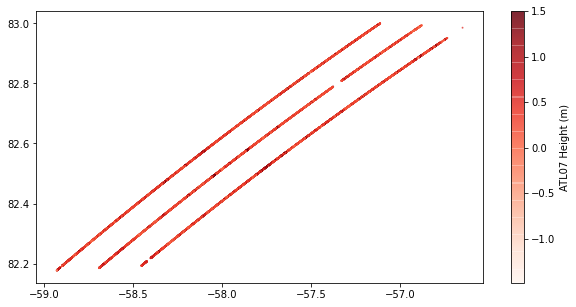

In [59]:
plt.subplots(figsize=(10,5)) # set size
#plt.pcolormesh(sst['lon'], sst['lat'], sst['sea_surface_temperature'], cmap='viridis')
plt.scatter(atl07.longitude, atl07.latitude,
          c=atl07.height_segment_height, vmax=1.5,
          cmap='Reds', alpha=0.6, s=1)    
plt.colorbar(label='ATL07 Height (m)')
plt.show()


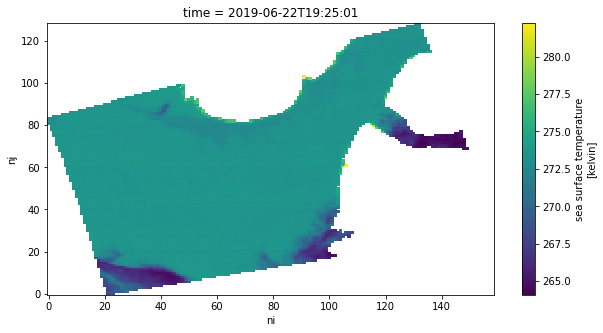

In [62]:
plt.subplots(figsize=(10,5)) # set size
sst['sea_surface_temperature'].plot(cmap='viridis');

# Move to different notebook: Point search testing...

Argo float data from [this search](https://nrlgodae1.nrlmry.navy.mil/cgi-bin/argo_select.pl?startyear=2020&startmonth=11&startday=01&endyear=2020&endmonth=11&endday=03&Nlat=75&Wlon=-80&Elon=-45&Slat=50&dac=ALL&floatid=ALL&gentype=plt&.submit=++Go++&.cgifields=endyear&.cgifields=dac&.cgifields=delayed&.cgifields=startyear&.cgifields=endmonth&.cgifields=endday&.cgifields=startday&.cgifields=startmonth&.cgifields=gentype)

Pull in file with lat lon point locations:

In [ ]:
df = pd.read_csv("argo-float-data.csv")
gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.Longitude, df.Latitude))
gdf

In [ ]:
gdf.to_file('argo-data.geojson', driver='GeoJSON')

curl -XPOST "https://cmr.earthdata.nasa.gov/search/granules" -F "shapefile=@argo-data.geojson;type=application/geo+json" -F "collection_concept_id=C1706334166-NSIDC_ECS" -F "page_size=100"

In [ ]:
search_url = "https://cmr.earthdata.nasa.gov/search/granules"
files = {"shapefile": ("argo-data.geojson", open('argo-data.geojson', 'r'), "application/geo+json")}
parameters = {
    "scroll": "true",
    "page_size": 100,
    # set any search criteria here
    "collection_concept_id": "C1706334166-NSIDC_ECS",
}
output_format = "json"
response = requests.post(f"{search_url}.{output_format}", data=parameters, files=files)

print("status:", response.status_code)
print("hits:", response.headers["CMR-Hits"])
pprint(response.json()["feed"]["entry"][0])
